# Topic Clustering using Sentence Embeddings

In [1]:
import os
import sys
path = '/home/piotr/projects/twitter'
path_data = os.path.join(path, 'data/clean/')
path_results = os.path.join(path, 'results/topics')
path_embeddings = '/home/piotr/nlp/cc.pl.300.vec'
sys.path.append(os.path.join(path, 'src'))

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import gc
import numpy as np
import pandas as pd
from itertools import chain, product
import re
import json
import matplotlib.pyplot as plt
from nltk import FreqDist, word_tokenize
import seaborn as sns
from tqdm.notebook import tqdm
from gensim.models import KeyedVectors
tqdm.pandas()
from twitter_models.embeddings import KTopicModel, KTopicModelCosine, DBSCANTopics
from twitter_tools.utils import read_files, batch
from sklearn.model_selection import StratifiedShuffleSplit
from functools import partial
import pdb
import gc
path_stopwords = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(path_stopwords, 'r') as f:
    for line in f:
        word = line.strip('\n')
        if word != 'nie':
            stopwords.append(word)
import ast

## Introduction
In this notebook, I evaluate Tweet topic clustering obtained through the method specified by Demszky et al. in accordance to the sentence embeddings method proposed by Arora et al. 2017. For each Tweet, its embedding was calculated as the weighted sum of its lemmatized tokens, where the weights where tokens' respective weights were inversly proportional to each token's probability of occurence, using a normalzing constant $a$, such that $w = \frac{a}{ap(w)}$ Clustering was done using Minibatch K Means clustering algorithm, using sample of 10% of the total unique tweets, stratified w.r.t the date and party alligiance, to ensure the representativeness of the results.

### Data loading
The data is loaded from the preprocessed files, additionally excluding the ids flagged as problematic by the analysis performed in the `preprocessing` notebook. The Tweets that included less than 50% of Polish vocabulary or were tagged as outliers are also removed. Below, I define a filter function which is used toegether with the data loader function `read_files` specified in the module `twitter_tools.utils`.

In [3]:
DROP_IDS = json.load(open(os.path.join(path, 'results/cleaning/DROP_IDS.json'), 'r'))
def filter_fun(df, cols: list, drop_ids: list, stopwords: list):
    df = df.loc[np.logical_not(df.id_str.isin(drop_ids)),:]
    df = df.loc[np.logical_not(df.retweet.apply(lambda x: ast.literal_eval(x))),:]
    df['lemmatized'] = df.lemmatized.astype(str).apply(lambda x: " ".join([x for x in x.split() if x not in stopwords]))
    nas = df['lemmatized'].str.len() == 0 #drop empty strings
    return df.loc[np.logical_not(nas),cols]
ff = partial(filter_fun, cols = ['lemmatized', 'day', 'source', 'user-id_str'], drop_ids = DROP_IDS, 
             stopwords = stopwords)

In [4]:
#load data:
data = pd.DataFrame()
for dat in tqdm(read_files(path_data, ndays = 84, dtype = str, filter_fun = ff)):
    data = data.append(dat)
data.drop_duplicates(inplace = True, subset = 'lemmatized')
print(f'Data loaded. Number of obs {data.shape[0]}')


Data loaded. Number of obs 2082391


### Grid Search
To identify the optimal clustering hyperparameters (number of centroids `k` and the `a` weighting constant, $10^{-3}$ in the original paper I performed a grid search over a range of parameters, computing the silhuette score by bootstrapping 30 random samples of 1000 tweets and within-cluster sum of squares.

In [5]:
def grid_search(data, folder_results, path_embeddings):
    #set up grid:
    keys = params.keys(); combs = product(*params.values()) #keys + all combinations of parameters
    grid = [dict(zip(keys, elem)) for elem in combs] #zip these toegether into a list of dicts
    
    #iterate
    for i, param in tqdm(enumerate(grid)): 
        ktp = KTopicModel(k = param["k"], a = param["a"], path_embeddings = path_embeddings)
        
        #fit the model
        ktp.fit(data)
        #evaluate:
        grid[i]['silhuette'] = ktp.evaluate(data, sample_size = round(0.1*len(data)))
        grid[i]['inertia'] = ktp.cluster.inertia_
        print(f'Done evaluating {i} out of {len(grid)}. \
        K: {grid[i]["k"]} \
        A: {grid[i]["a"]} \
        Silhuette score {round(grid[i]["silhuette"], 4)}. \
        Inertia {round(grid[i]["inertia"], 4)}')
        #save:
        pickle.dump(ktp, open(os.path.join(path_results, f'cluster_k_{ktp.k}_a_{ktp.a}.p'), 'wb'))
        json.dump(grid, open(os.path.join(folder_results, 'grid_search.json'), 'w'))
        del(ktp)
        gc.collect()
    return grid

In [ ]:
%%time
path_comparison = os.path.join(path_results, 'grid_search.json')
if os.path.isfile(path_comparison):
    results = json.load(open(path_comparison, 'r'))
else:
    #get splits
    splitter = StratifiedShuffleSplit(n_splits = 1, train_size = 0.2, random_state = 1234)
    tr, ts = next(splitter.split(data, data['day'] + data['source']))
    print(f'Train size {tr.shape[0]}')
    #run grid search:
    params = {'k':list(range(3, 15)), 'a':[1e-3, 1e-4]}
    results = grid_search(data['lemmatized'].iloc[tr], path_results, path_embeddings)

#### Evaluate the same, but using cosine similarity as the distance metric:

In [6]:
def grid_search_cosine(data, folder_results, path_embeddings):
    #set up grid:
    keys = params.keys(); combs = product(*params.values()) #keys + all combinations of parameters
    grid = [dict(zip(keys, elem)) for elem in combs] #zip these toegether into a list of dicts
    #iterate
    for i, param in tqdm(enumerate(grid)): 
        ktp = KTopicModelCosine(k = param['k'], a = param['a'], path_embeddings = path_embeddings)
        
        #fit the model
        ktp.fit(data)
        #evaluate:
        grid[i]['silhuette'] = ktp.evaluate(data, sample_size = round(0.1*len(data)), metric = 'cosine')
        #save:
        pickle.dump(ktp, open(os.path.join(path_results, f'cluster_k_{ktp.k}_a_{ktp.a}.p'), 'wb'))
        json.dump(grid, open(os.path.join(folder_results, 'grid_search.json'), 'w'))
        del(ktp)
        gc.collect()
    return grid

In [7]:
%%time
path_comparison = os.path.join(path_results, 'grid_search.json')
if os.path.isfile(path_comparison):
    results = json.load(open(path_comparison, 'r'))
else:
    #get splits
    splitter = StratifiedShuffleSplit(n_splits = 1, train_size = 0.2, random_state = 1234)
    tr, ts = next(splitter.split(data, data['day'] + data['source']))
    print(f'Train size {tr.shape[0]}')
    #run grid search:
    params = {'k':range(2, 10), 'a':[1e-3, 1e-4]}
    results = grid_search_cosine(data['lemmatized'].iloc[tr], path_results, path_embeddings)

Train size 416478



CPU times: user 2h 58min 18s, sys: 18min 13s, total: 3h 16min 31s
Wall time: 2h 37min 11s


### Evaluation methods:
The models were compared on the following criteria:

**1. Measures of clustering fit - silhuette score computed by bootstrapping and within-cluster sum of squares**

a
0.0001    AxesSubplot(0.125,0.125;0.775x0.755)
0.0010    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

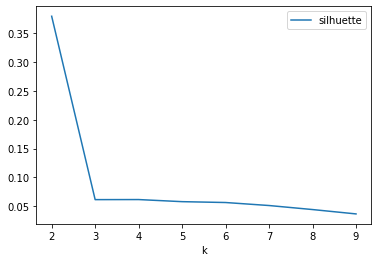

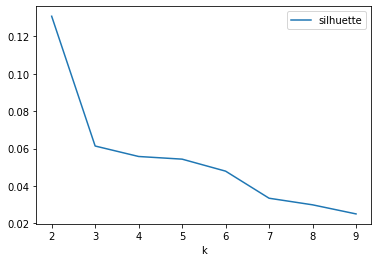

In [11]:
results = pd.DataFrame(json.load(open(path_comparison, 'r')))
results.groupby('a').plot('k','silhuette')

**2. Closest word vectors to cluster centroids**

In [14]:
fasttext = KeyedVectors.load_word2vec_format('/home/piotr/nlp/cc.pl.300.vec')

In [36]:
def plot_n_closest(ktp, gensim_model, topn = 20):
    """
    Function to plot n closest words in terms of word vectors
    """
    #get n closest words to each centroid:
    res = dict()
    for k, center in enumerate(ktp.cluster.means()):
        res[k] = gensim_model.similar_by_vector(center, topn = topn)
        
    #plot
    fig = plt.figure(figsize = (15, 10))
    for i in res:
        ax = fig.add_subplot(np.ceil(np.sqrt(len(res))), np.ceil(np.sqrt(len(res))), i + 1,)
        ax.barh([j[0] for j in res[i]], [j[1] for j in res[i]])
        ax.set_title(f'Topic {i}')
    plt.tight_layout()
    plt.show()   

**3. Most common tokens in each cluster that didn't occur in the most common words of other clusters**

In [5]:
def predict_clusters(model, text, batch_size = 500000):
    """
    Function used to predict clusters in batches to limit memory usage.
    """
    clusters = []
    for txt in tqdm(batch(text, batch_size)):
        clusters.extend(model.predict(text))
    clusters = dict(zip(text, clusters))
    return clusters
        
    
def map_clusters(data, cls, col_id = 'lemmatized'):
    """
    Function to map clustering dictionary onto the data by identifying variable
    """
    data['cluster'] = data[col_id].map(cls)
    data.dropna(subset = ['cluster'], inplace = True)
    data.reset_index(inplace = True, drop = True)
    return data


def eval_topics(text, labels, n = 100):
    """
    Function to get distributions of most common
    tokens in each topic that were not amongst the 
    most common tokens in other topics.
    """
    dists = dict()
    for i in np.unique(labels):
        txt = text[labels == i]
        freq = FreqDist(chain.from_iterable(txt))
        dists[i] = freq.most_common(n)
    dists_unique = dict()
    for i, dist in dists.items():
        #get vocabulary of all other topics but i
        rest = []
        _ = [rest.extend([el[0] for el in v]) for k, v in dists.items() if k != i]
        #filter out those not included in the vocabulary of topic i
        dists_unique[i] = {k:v for k, v in dist if k not in rest}
    return dists_unique

def clustering_summary(text, labels, source, **kwargs):
    """
    Function to create summaries of the clustering results - most common tokens
    in each topic + the split among the parties and count
    """
    dists = eval_topics(text, labels, **kwargs)
    dists_nocounts = {k:[", ".join(list(v))] for k, v in dists.items()}
    df =  pd.DataFrame.from_dict(dists_nocounts, orient = "index")
    sources = pd.crosstab(labels, source)
    df = pd.merge(df, sources, left_index = True, right_index = True)
    df["count"] = df[["gov","opp"]].sum(axis = 1)
    df.columns = ["tokens","gov","opp","count"]
    return df, dists

def plot_words(dists, **kwargs):
    """
    Function to plot most common tokens in each topic
    in one figure.
    """
    fig_side = np.ceil(np.sqrt(len(dists)))
    fig = plt.figure(**kwargs)
    for i, (k, fdist) in enumerate(dists.items()):
        ax = fig.add_subplot(fig_side, fig_side, i + 1)
        ax.set_title(f"Topic {k}")
        ax.barh(y = list(fdist.keys())[:10], width = list(fdist.values())[:10])
    plt.tight_layout()
    plt.show()

**4. Topic distribution**
 - overall
 - between parties
 - temporal

In [6]:
def plot_dists(data, **kwargs):
    """
    Function to plot token distributions of the clusters.
    """
    
    #prepare plot
    fig, ax = plt.subplots(3, 1, **kwargs)
    ax = ax.ravel()
    
    
    #OVERALL DISTRIBUTION
    tab = pd.value_counts(data.cluster, normalize = True)
    tab.plot.bar(ax = ax[0])
    #get mapping for the next plot:
    mapping = {k:i for i, (k, v) in enumerate(sorted(tab.items(), key = lambda x: x[1], reverse = True))}
    ax[0].axes.get_xaxis().set_visible(False)
    
    
    
    #BETWEEN-PARTY DISTRIBUTION
    crosstab = pd.crosstab(data.cluster, data.source, normalize = "index")
    #order according to size:
    key = crosstab.reset_index().cluster.map(mapping)
    crosstab = crosstab.iloc[key.argsort()]
    crosstab.plot.bar(ax = ax[1], stacked = True)
    ax[1].set_xlabel("Topic number")
    ax[1].legend(["Government", "Opposition"])
    
    
    #TEMPORAL DISTRIBUTION
    pd.crosstab(data.day, data.cluster, normalize = "index").plot.bar(stacked = True, rot = 45, ax = ax[2])
    ticks = np.arange(0, len(data.day.unique()), 4) #every fourth tick
    ax[2].set_xticks(ticks)
    ax[2].set_xticklabels(np.array(sorted(data.day.unique()))[ticks])
    
    #label
    font = {'size'   : 18}
    fig.text(-0.01, 0.5, 'Propotion of tweets', va='center', rotation='vertical', fontdict = font)
    #show
    plt.tight_layout()
    plt.show()

### K = 5 a = 0.0001

In [7]:
path_model = os.path.join(path, 'results/topics/cluster_k_5_a_0.0001.p')

In [8]:
ktp = pickle.load(open(path_model, 'rb'))

2. **Closest words for cluster centroids**

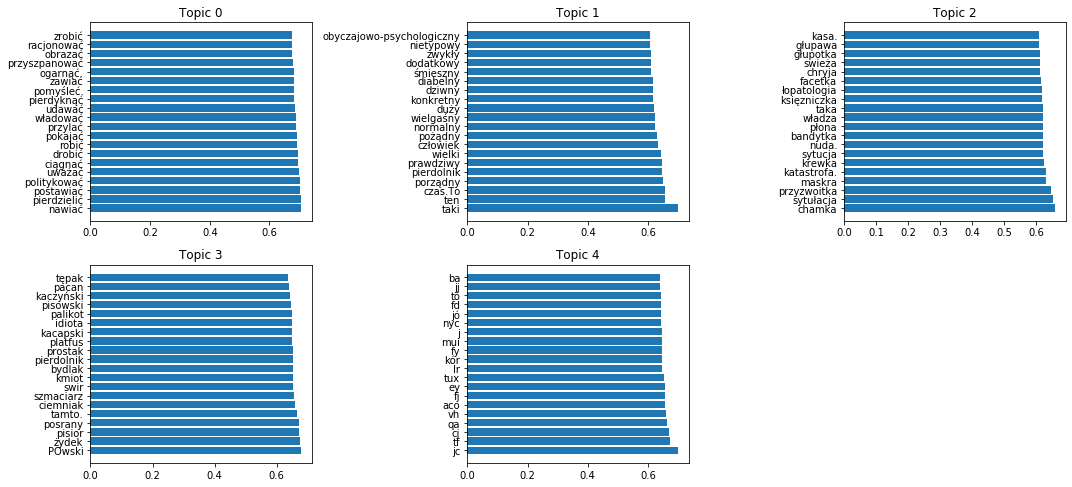

In [37]:
plot_n_closest(ktp, fasttext)

**3. Most common unique tokens**

In [ ]:
#get predictions of topics
path_topics = path_model.replace('.p', '.json')
if os.path.isfile(path_topics):
    cls = json.load(open(os.path.join(path_topics),'r'))
else:
    cls = predict_clusters(ktp, data['lemmatized'].astype(str), batch_size = 100000)
    json.dump(cls, open(os.path.join(path_topics),'w'))

In [ ]:
#get best match for each id
cls = {k:sorted(v.items(), key = lambda x: x[1], reverse = True)[0][0] for k, v in cls.items()}
data = map_clusters(data, cls)

In [ ]:
df, dists = clustering_summary(data.lemmatized.astype(str).apply(lambda x: x.split()), 
                          data.cluster.astype(int),
                       data.source)
df

In [ ]:
plot_words(dists, figsize = (10, 10))

**4. Distributions**

In [ ]:
plot_dists(data, figsize = (14, 10))

### K = 10, a = 0.0001

In [44]:
path_model = os.path.join(path, 'results/topics/cluster_k_9_a_0.0001.p')

In [45]:
ktp = pickle.load(open(path_model, 'rb'))

**2. Closest centroids**

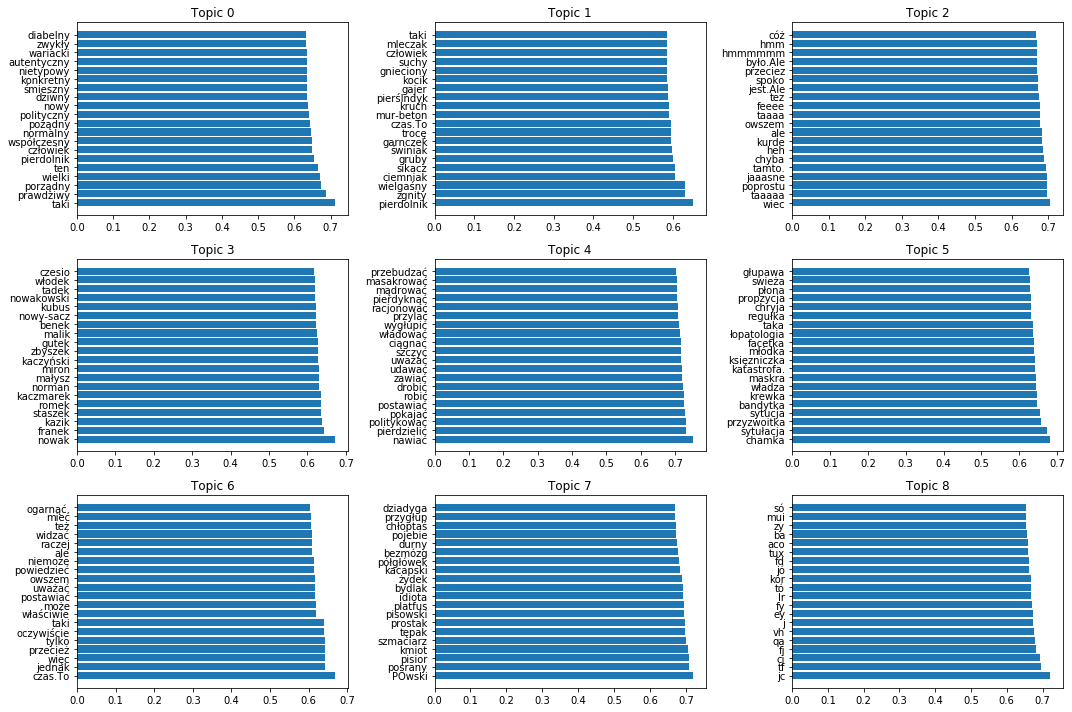

In [51]:
plot_n_closest(ktp, fasttext)

**3. Most common unique tokens**

In [ ]:
#get predictions of topics
path_topics = path_model.replace('.p', '.json')
if os.path.isfile(path_topics):
    cls = json.load(open(os.path.join(path_topics),'r'))
else:
    cls = predict_clusters(ktp, data['lemmatized'].astype(str), batch_size = 10000)
    json.dump(cls, open(os.path.join(path_topics),'w'))

In [ ]:
#get best match for each id
cls = {k:sorted(v.items(), key = lambda x: x[1], reverse = True)[0][0] for k, v in cls.items()}
data = map_clusters(data, cls)

In [ ]:
df, dists = clustering_summary(data.lemmatized.astype(str).apply(lambda x: x.split()), 
                          data.cluster.astype(int),
                       data.source)
df

In [ ]:
plot_words(dists, figsize = (10, 10))

**4. Distributions**

In [ ]:
plot_dists(data, figsize = (14, 10))